In [1]:
import argparse
import tifffile
import dask
import zarr
import dask_image
import skimage
import numpy as np
import cv2 as cv
import spatialdata as sd
import matplotlib.pyplot as plt
import spatialdata_io
import spatialdata_plot
from spatialdata.models import Image2DModel

/omics/odcf/analysis/OE0536_projects/spatialomicsdata/MICHELE/CODEX_XENIUM/multimodal/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
# Read the comet image
comet_img = tifffile.imread("COMET/20240115_140647_2_IntG77_Spyre_FFPE_Sequential IF_QB2.tiff", aszarr=True)
comet_img = zarr.open(comet_img, mode='r')
comet_img = dask.array.from_zarr(comet_img["0"])
comet_img

dask.array<from-zarr, shape=(17, 39651, 39532), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>

In [3]:
# Load the xenium ouptut
aligned = spatialdata_io.xenium(
    "XENIUM/",
    cells_boundaries=True,
    nucleus_boundaries=False,
    cells_as_circles=False,
    cells_labels=True,
    nucleus_labels=False,
    transcripts=True,
    morphology_mip=True,
    morphology_focus=False,
    aligned_images=False,
    cells_table=True,
    n_jobs=8,
)

/usr/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [4]:
aligned

SpatialData object
├── Images
│     └── 'morphology_mip': DataTree[cyx] (1, 23866, 45409), (1, 11933, 22704), (1, 5966, 11352), (1, 2983, 5676), (1, 1491, 2838)
├── Labels
│     └── 'cell_labels': DataTree[yx] (23866, 45409), (11933, 22704), (5966, 11352), (2983, 5676), (1491, 2838)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     └── 'cell_boundaries': GeoDataFrame shape: (262183, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (262183, 345)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_mip (Images), cell_labels (Labels), transcripts (Points), cell_boundaries (Shapes)

In [5]:
SCALE_FACTOR = aligned["morphology_mip"]["scale0"].image.shape[1] / aligned["morphology_mip"]["scale3"].image.shape[1]
matrix = np.array([[SCALE_FACTOR, 0, 0], [0, SCALE_FACTOR, 0], [0, 0, 1]])
# Downscaling comet DAPI
output_shape = np.asarray(comet_img[0, :, :].shape)
output_shape = (output_shape / SCALE_FACTOR).astype("uint16")

dna_comet = comet_img.squeeze()[0, :, :]
dna_comet = dask_image.ndinterp.affine_transform(
    dna_comet,
    matrix=matrix,
    output_shape=output_shape,
)
dna_comet = skimage.exposure.equalize_adapthist(dna_comet)
dna_comet = (
    (dna_comet - np.min(dna_comet)) / (np.max(dna_comet) - np.min(dna_comet)) * 255
)
dna_comet = dna_comet.astype("uint8")
dna_comet

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], shape=(4955, 4941), dtype=uint8)

In [6]:
# Downscaling Xenium Morphology focus DAPI
dna_mf = aligned["morphology_mip"]["scale3"].image
dna_mf = (dna_mf - np.min(dna_mf)) / (np.max(dna_mf) - np.min(dna_mf)) * 255
dna_mf = dna_mf.astype("uint8")
dna_mf = dna_mf.compute()
dna_mf = dna_mf[0,...].to_numpy()
dna_mf

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2983, 5676), dtype=uint8)

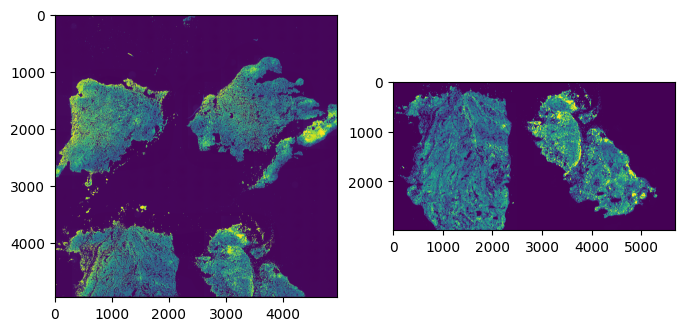

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
axs[0].imshow(dna_comet)
axs[1].imshow(dna_mf)

In [8]:
def get_align_matrix(img1, img2, scale_factor=1):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    FLANN_INDEX_KDTREE = 1
    index_params = {"algorithm": FLANN_INDEX_KDTREE, "trees": 5}
    search_params = {"checks": 50}
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)
    
    pt1 = []
    pt2 = []
    for n, m in enumerate(good):
        pt1.append(kp1[m.queryIdx].pt)
        pt2.append(kp2[m.trainIdx].pt)
    pt1 = np.asarray(pt1)
    pt2 = np.asarray(pt2)

    landmarks1 = sd.models.ShapesModel.parse(pt1, geometry=0, radius=5)
    landmarks2 = sd.models.ShapesModel.parse(pt2, geometry=0, radius=5)
    
    affine = sd.transformations.get_transformation_between_landmarks(
        landmarks2, landmarks1
    )
    affine = affine.inverse().matrix
    affine[0:2, 2] *= scale_factor

    
    def matrix_rc2xy(affine_matrix):
        swapped_cols = affine_matrix[:, [1, 0, 2]]
        swapped_rows = swapped_cols[[1, 0, 2], :]
        return swapped_rows

    affine = matrix_rc2xy(affine)

    return  affine

In [15]:
aff_yx_scaled = get_align_matrix(dna_mf, dna_comet, scale_factor=SCALE_FACTOR)

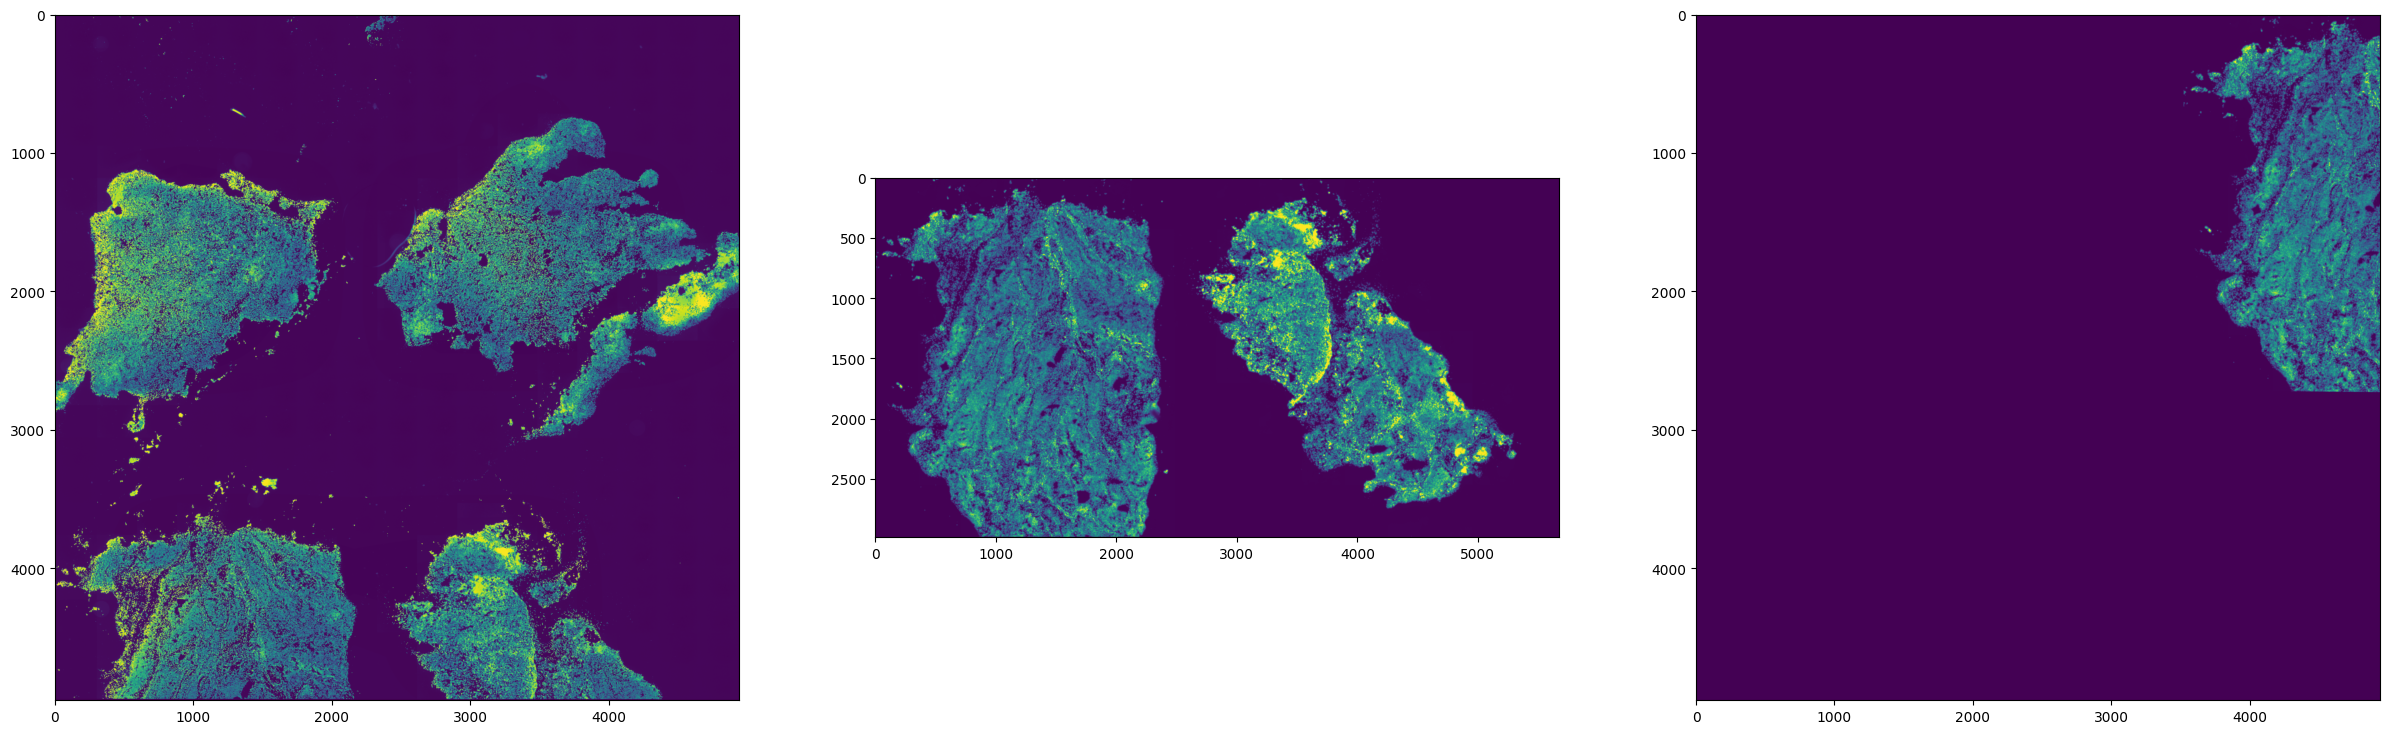

In [16]:
# Just to test the alignment
aff_yx_unscaled = get_align_matrix(dna_mf, dna_comet, scale_factor=1)
test_img = skimage.transform.warp(image=dna_mf, inverse_map=aff_yx_unscaled, output_shape=dna_comet.shape)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(30, 10))
axs[0].imshow(dna_comet)
axs[1].imshow(dna_mf)
axs[2].imshow(test_img)

In [17]:
comet_sd = sd.models.Image2DModel()
comet_sd = comet_sd.parse(comet_img, scale_factors=[2,2,2,2],
                          c_coords=("DAPI", "TRITC", "Cy5", "CD3", "FOXP3", "CD4", "CD8", "CD56", "CD20", "CD11c",
                                    "CD68", "PDL1", "SMA", "PD1", "CD45", "ki67-1", "ki67-2"),
                          transformations={"comet":sd.transformations.Identity()})
comet_sd

<xarray.DataTree>
Group: /
├── Group: /scale0
│       Dimensions:  (c: 17, y: 39651, x: 39532)
│       Coordinates:
│         * c        (c) <U6 408B 'DAPI' 'TRITC' 'Cy5' ... 'CD45' 'ki67-1' 'ki67-2'
│         * y        (y) float64 317kB 0.5 1.5 2.5 3.5 ... 3.965e+04 3.965e+04 3.965e+04
│         * x        (x) float64 316kB 0.5 1.5 2.5 3.5 ... 3.953e+04 3.953e+04 3.953e+04
│       Data variables:
│           image    (c, y, x) uint16 53GB dask.array<chunksize=(17, 256, 256), meta=np.ndarray>
├── Group: /scale1
│       Dimensions:  (c: 17, y: 19825, x: 19766)
│       Coordinates:
│         * c        (c) <U6 408B 'DAPI' 'TRITC' 'Cy5' ... 'CD45' 'ki67-1' 'ki67-2'
│         * y        (y) float64 159kB 1.0 3.0 5.0 7.0 ... 3.965e+04 3.965e+04 3.965e+04
│         * x        (x) float64 158kB 1.0 3.0 5.0 7.0 ... 3.953e+04 3.953e+04 3.953e+04
│       Data variables:
│           image    (c, y, x) uint16 13GB dask.array<chunksize=(17, 256, 256), meta=np.ndarray>
├── Group: /scale2
│       Dimensions:  (c: 17, y: 9912, x: 9883)
│       Coordinates:
│         * c        (c) <U6 408B 'DAPI' 'TRITC' 'Cy5' ... 'CD45' 'ki67-1' 'ki67-2'
│         * y        (y) float64 79kB 2.0 6.0 10.0 ... 3.964e+04 3.964e+04 3.965e+04
│         * x        (x) float64 79kB 2.0 6.0 10.0 ... 3.952e+04 3.953e+04 3.953e+04
│       Data variables:
│           image    (c, y, x) uint16 3GB dask.array<chunksize=(17, 256, 256), meta=np.ndarray>
├── Group: /scale3
│       Dimensions:  (c: 17, y: 4956, x: 4941)
│       Coordinates:
│         * c        (c) <U6 408B 'DAPI' 'TRITC' 'Cy5' ... 'CD45' 'ki67-1' 'ki67-2'
│         * y        (y) float64 40kB 4.0 12.0 20.0 ... 3.963e+04 3.964e+04 3.965e+04
│         * x        (x) float64 40kB 4.0 12.0 20.0 ... 3.951e+04 3.952e+04 3.953e+04
│       Data variables:
│           image    (c, y, x) uint16 833MB dask.array<chunksize=(17, 256, 256), meta=np.ndarray>
└── Group: /scale4
        Dimensions:  (c: 17, y: 2478, x: 2470)
        Coordinates:
          * c        (c) <U6 408B 'DAPI' 'TRITC' 'Cy5' ... 'CD45' 'ki67-1' 'ki67-2'
          * y        (y) float64 20kB 8.001 24.0 40.0 ... 3.961e+04 3.963e+04 3.964e+04
          * x        (x) float64 20kB 8.002 24.01 40.01 ... 3.951e+04 3.952e+04
        Data variables:
            image    (c, y, x) uint16 208MB dask.array<chunksize=(17, 256, 256), meta=np.ndarray>

In [18]:
aligned["comet_image"] = comet_sd
# Transcripts have a scale transform in the "global" coordinate system
# we need to keep it and add it to the affine in order
scale = sd.transformations.get_transformation(aligned["transcripts"], to_coordinate_system="global") 
affine = sd.transformations.Affine(np.linalg.inv(aff_yx_scaled), input_axes=("y", "x"), output_axes=("y", "x"))
sd.transformations.set_transformation(aligned["morphology_mip"], transformation=affine, to_coordinate_system="comet")
sd.transformations.set_transformation(aligned["cell_labels"], transformation=affine, to_coordinate_system="comet")
sd.transformations.set_transformation(aligned["transcripts"], transformation=sd.transformations.Sequence([scale, affine]), to_coordinate_system="comet")
sd.transformations.set_transformation(aligned["cell_boundaries"], transformation=affine, to_coordinate_system="comet")

aligned

SpatialData object
├── Images
│     ├── 'comet_image': DataTree[cyx] (17, 39651, 39532), (17, 19825, 19766), (17, 9912, 9883), (17, 4956, 4941), (17, 2478, 2470)
│     └── 'morphology_mip': DataTree[cyx] (1, 23866, 45409), (1, 11933, 22704), (1, 5966, 11352), (1, 2983, 5676), (1, 1491, 2838)
├── Labels
│     └── 'cell_labels': DataTree[yx] (23866, 45409), (11933, 22704), (5966, 11352), (2983, 5676), (1491, 2838)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     └── 'cell_boundaries': GeoDataFrame shape: (262183, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (262183, 345)
with coordinate systems:
    ▸ 'comet', with elements:
        comet_image (Images), morphology_mip (Images), cell_labels (Labels), transcripts (Points), cell_boundaries (Shapes)
    ▸ 'global', with elements:
        morphology_mip (Images), cell_labels (Labels), transcripts (Points), cell_boundaries (Shapes)

In [20]:
aligned.write("ALIGNED.zarr", overwrite=True)

In [ ]:
# Just for testing the alignment
aligned = sd.read
del aligned["transcripts"]
crop = sd.bounding_box_query(aligned, axes=("y", "x"), target_coordinate_system="comet", min_coordinate=np.asarray((33000,10000)), max_coordinate=np.asarray((34000,11000)))
crop.pl.render_images("comet_image", channel="DAPI", cmap="Greens", alpha=0.5).pl.render_images("morphology_mip", alpha=0.5, cmap="Reds").pl.show(coordinate_systems="comet")